In [20]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import io
import pandas as pd
from jax import grad
import jax.numpy as jnp
import numpy.random as npr
from sklearn.metrics import accuracy_score
import seaborn as sns

## Logistic Regression Helper Functions

In [22]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def logistic_predictions(weights, x):
    # Outputs probability of a label being true according to logistic model.
    return sigmoid(np.dot(x, weights))


## Load Breast Cancer Data and Scale

In [23]:
breast_cancer = load_breast_cancer()

X, y = breast_cancer.data, breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler() 
scaler.fit(X_train) 
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [24]:
def log_reg(X_train, y_train, X_test, y_test, n_epochs, minibatch_size, eta, lmbd):
    
    npoints = len(X)
    
    #initialize weights
    weights = np.zeros(X_train.shape[1])

    M = minibatch_size 
    m = int(npoints/M) 
    
    #set momentum and change values for SGD
    momentum = 0.8
    change = 0.1
    
    # intialize empty list for predictions
    predictions = []
    
    #iterate over each epoch
    for epoch in range(n_epochs):
        
        for i in range(m):
            #iterate over each minibatch and select data
            random_index = M*npr.randint(m)
            xi = X_train[random_index:random_index+M]
            yi = y_train[random_index:random_index+M]
            
            # calculate gradient
            z = xi@weights
            p = sigmoid(z)
            gradient = (xi.T @ (p - yi) - 2*lmbd*weights)/npoints

            new_change = eta * gradient + momentum * change

            weights -= new_change

            change = new_change
        
        # make predictions using logisitic_predictions (which feeds through a sigmoid function)
        ypred = logistic_predictions(weights, X_test)
        predictions.append(ypred)
    
    # calculate accuracies on test data based on threshold of 0.5
    accuracies = []
    for i in range(len(predictions)):
        ypred_ints = []
        for j in predictions[i]:
            if j < 0.5:
                ypred_ints.append(0)
            else:
                ypred_ints.append(1)
        
        accuracies.append(accuracy_score(y_test, ypred_ints))

        
    return accuracies

## Do grid search over learning rate and lambdas to find best model

In [25]:
etas = np.array([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
lmbdas = np.array([0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])

log_reg_grid = np.zeros((len(etas), len(lmbdas)))
                        
for eta,i in zip(etas, range(len(etas))):
    for lmbd,j in zip(lmbdas, range(len(lmbdas))):
        test_accuracies = log_reg(X_train_scaled, y_train, X_test_scaled, y_test, 
                                n_epochs=100, minibatch_size=10, eta=eta, lmbd=lmbd)
                        
        final_acc = test_accuracies[-1]
        log_reg_grid[i,j] = final_acc
    print(i)

0
1
2
3
4
5


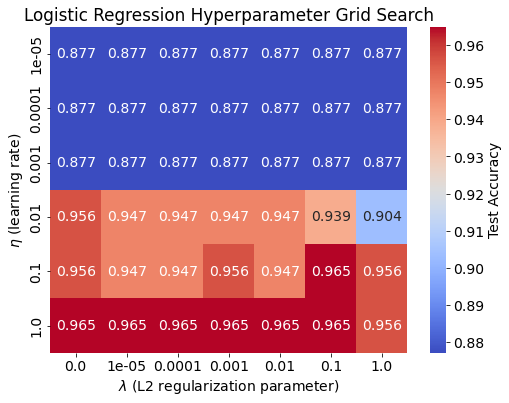

In [35]:
plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(figsize=(8,6))

sns.heatmap(log_reg_grid, annot=True, cmap='coolwarm', fmt='.3g', cbar_kws={'label': 'Test Accuracy'})
ax.set_xticklabels(lmbdas.round(5))
ax.set_yticklabels(etas.round(5))
ax.set_ylabel("$\\eta$ (learning rate)")
ax.set_xlabel("$\\lambda$ (L2 regularization parameter)")
ax.set_title('Logistic Regression Hyperparameter Grid Search')
#fig.savefig('log_reg_grid_search.jpg', dpi=1000, bbox_inches='tight')

## Use best model params (eta = 1, lmbd = 0) and worst that worked (eta = 0.01, lmbd=1) to compare.

In [27]:
test_acc_eta1_lmbd0 = log_reg(X_train_scaled, y_train, X_test_scaled, y_test, 
                              n_epochs=100, minibatch_size=10, eta=1, lmbd=0)

test_acc_eta001_lmbd1 = log_reg(X_train_scaled, y_train, X_test_scaled, y_test, 
                              n_epochs=100, minibatch_size=10, eta=0.01, lmbd=1)

test_acc_eta1_lmbd0_unscaled = log_reg(X_train, y_train, X_test, y_test, 
                              n_epochs=100, minibatch_size=10, eta=1, lmbd=0)

test_acc_eta001_lmbd1_unscaled = log_reg(X_train, y_train, X_test, y_test, 
                              n_epochs=100, minibatch_size=10, eta=0.01, lmbd=1)

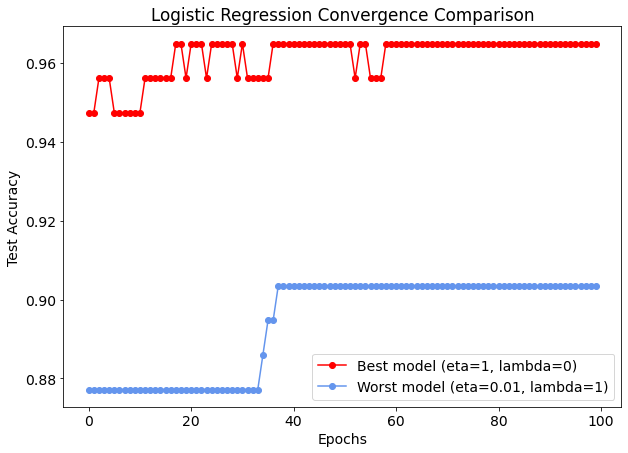

In [31]:
plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(figsize=(10,7))
ax.plot(test_acc_eta1_lmbd0, '-o', color='red', label='Best model (eta=1, lambda=0)')
ax.plot(test_acc_eta001_lmbd1, '-o', color='cornflowerblue', label='Worst model (eta=0.01, lambda=1)')

ax.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Test Accuracy')
ax.set_title('Logistic Regression Convergence Comparison')
#fig.savefig('log_reg_best_vs_worst.jpg', dpi=1000, bbox_inches='tight')

### test the impact of data scaling

In [32]:
test_acc_eta1_lmbd0_unscaled = log_reg(X_train, y_train, X_test, y_test, 
                              n_epochs=100, minibatch_size=10, eta=1, lmbd=0)

test_acc_eta001_lmbd1_unscaled = log_reg(X_train, y_train, X_test, y_test, 
                              n_epochs=100, minibatch_size=10, eta=0.01, lmbd=1)

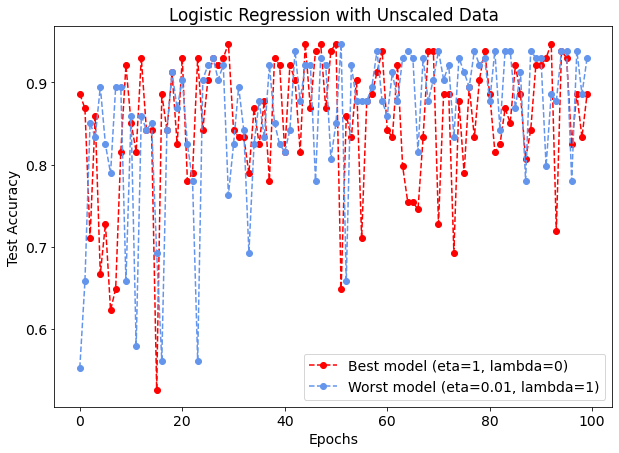

In [33]:
fig,ax = plt.subplots(figsize=(10,7))

ax.plot(test_acc_eta1_lmbd0_unscaled, '--o', color='red', label='Best model (eta=1, lambda=0)')
ax.plot(test_acc_eta001_lmbd1_unscaled, '--o', color='cornflowerblue', label='Worst model (eta=0.01, lambda=1)')
ax.legend()
ax.set_title('Logistic Regression with Unscaled Data')
#ax.set_ylim(0.39, 0.965)
ax.set_xlabel('Epochs')
ax.set_ylabel('Test Accuracy')
#fig.savefig('log_reg_scaled_vs_unscaled.jpg', dpi=1000, bbox_inches='tight')